## Setup

In [1]:
%reload_ext autoreload
%autoreload 2
from termcolor import colored
import dotenv
import sys
import dspy
import os

from tqdm.auto import tqdm

sys.path.append('../pipeline_v2/')
import main
dotenv.load_dotenv('../.env', override=True)

from utils import print_header

import pandas as pd

def print_final_result(statement, verdict, confidence, reasoning, gold_verdict=None):
    # Print final result
    print("\nFinal Fact-Check Result:")
    print_header(f"Statement: {colored(statement, 'white')}", level=1)
    print_header(f"Overall Verdict: {colored(verdict, 'green')}", level=1)
    print_header(f"Overall Confidence: {colored(str(confidence), 'yellow')}", level=1)
    print_header(f"Overall Reasoning: {colored(reasoning, 'cyan')}", level=1)
    if gold_verdict: print_header(f"Gold Verdict: {colored(gold_verdict, 'green')}", level=1)

/opt/homebrew/Caskroom/miniforge/base/envs/RAG/lib/python3.10/site-packages/pydantic/_internal/_config.py:345: UserWarning: Valid config keys have changed in V2:
* 'fields' has been removed
  warnings.warn(message, UserWarning)


In [2]:
# Set custom constants for whole pipeline
main.VERBOSE = False # Print intermediate results
# main.VERDICTS=["Supported", "Refuted", "Not Enough Evidence", "Conflicting Evidence/Cherry-picking"]

# Initialize DSPy
lm = dspy.LM('gemini/gemini-1.5-flash', api_key=os.getenv('GOOGLE_GEMINI_API_KEY'), cache=False)
# lm = dspy.LM('ollama_chat/mistral-custom', api_base='http://localhost:11434', api_key='', cache=False)
# lm = dspy.LM('openrouter/mistralai/mistral-7b-instruct:free', api_key=os.getenv('OPENROUTER_API_KEY'), cache=False)
# lm = dspy.LM('ollama_chat/llama3.1:8b', api_base='http://localhost:11434', api_key='', cache=False)
# lm = dspy.LM('openrouter/meta-llama/llama-3.1-8b-instruct:free', api_key=os.getenv('OPENROUTER_API_KEY'), cache=False)
# lm = dspy.LM('ollama_chat/deepseek-r1:7b', api_base='http://localhost:11434', api_key='', cache=False)
# lm = dspy.LM('openrouter/deepseek/deepseek-r1-distill-llama-70b:free', api_key=os.getenv('OPENROUTER_API_KEY'), cache=False)
# lm = dspy.LM('openrouter/deepseek/deepseek-r1:free', api_key=os.getenv('OPENROUTER_API_KEY'), cache=False)
dspy.settings.configure(lm=lm, temperature=0.3)

pipeline = main.FactCheckPipeline(
    # search_provider=main.SearchProvider(provider="duckduckgo"),
    search_provider=main.SearchProvider(provider="serper", api_key=os.getenv('SERPER_API_KEY')),
    model_name=lm, 
    embedding_model=main.EMBEDDING_MODEL,
    retriever_k=5
)

In [3]:
### Load data
if os.path.exists('results_v2.pkl'):
    df = pd.read_pickle('results_v2.pkl')
else: 
    df = pd.read_csv('../data/pilot_updated_v3.csv')

    # # Drop unneeded columns
    df.drop(columns=['Assignee', 'questions to verify the statement', 'Gold Label', 'factcheck_date'], inplace=True)

    # Reformat dates
    df['statement_date'] = pd.to_datetime(df['statement_date']).dt.strftime("%B %d, %Y")

# df

## Search Testing

In [ ]:
pipeline_val.search_provider.search('what is the capital of France?')

In [ ]:
from duckduckgo_search import DDGS
from itertools import cycle

proxy_pool = """
143.107.199.248:8080
""".strip().split('\n')
# 98.80.66.1:10018

proxy_cycle = cycle(proxy_pool)

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
}

def get_results_with_rotation(query, num_results):
    while True:
        current_proxy = next(proxy_cycle)
        try:
            with DDGS(proxy={'http': current_proxy, 'https': current_proxy}, headers=headers) as ddgs:
                results = ddgs.text(query.lower(), max_results=num_results)
            print(f"Success with proxy {current_proxy}")
            return results
        except Exception as e:
            print(f"Error with proxy {current_proxy}: {e}")
            continue

get_results_with_rotation('google stock price', 10)

## Pipeline

In [ ]:
# Test with a single statement from dataset
index = 35
statement = df.iloc[index]['statement']
statement_originator = df.iloc[index]['statement_originator']
statement_date = df.iloc[index]['statement_date']
gold_verdict = df.iloc[index]['verdict']

pipeline_val.retriever.clear()
verdict, confidence, reasoning, claims = pipeline_val.fact_check(
    # statement=f"According to {statement_originator} on {statement_date}, {statement}", 
    statement=f"On {statement_date}, {statement_originator} claimed: {statement}", 
    # statement=statement, 
    # context=f"Statement Originator: {statement_originator}, Date Claim Was Made: {statement_date}"
)
print_final_result(statement, verdict, confidence, reasoning, gold_verdict)

In [ ]:
lm.inspect_history(n=10)

In [ ]:
model = 'gemini-1.5-pro'
num_trials = 3

# If column doesn't exist, create it
if f'{model}_results' not in df.columns: df[f'{model}_results'] = None
df[f'{model}_results'] = df[f'{model}_results'].astype(object)

for index in tqdm(range(len(df))):
    # If results already exist, skip if num_trials is reached
    if df.loc[index, f'{model}_results'] is not None: 
        if len(df.loc[index, f'{model}_results']) == num_trials:
            continue
        else:
            results = df.loc[index, f'{model}_results']
    else: 
        results = []

    for trial_i in tqdm(range(num_trials), leave=False):
        statement = df.iloc[index]['statement']
        statement_originator = df.iloc[index]['statement_originator']
        statement_date = df.iloc[index]['statement_date']
        gold_verdict = df.iloc[index]['verdict']

        verdict, confidence, reasoning, claims = pipeline_val.fact_check(
            statement=statement, 
            context=f"Statement Originator: {statement_originator}, Date Claim Was Made: {statement_date}"
        )
        results.append({
            'verdict': verdict,
            'confidence': confidence,
            'reasoning': reasoning,
            'claims': claims
        })

        print_final_result(statement, verdict, confidence, reasoning, gold_verdict)

    # Update the dataframe
    df.at[index, f'{model}_results'] = results

In [11]:
df.to_pickle('results_v2.pkl')

## Baseline

In [40]:
 class StatementFactCheckerSignature(dspy.Signature):
    f"""Fact check the given statement into one of the following verdicts: {", ".join(main.VERDICTS)}"""
    statement = dspy.InputField(desc="Statement to evaluate")
    verdict = dspy.OutputField(desc=f"Truthful classification of the statement into one of the following verdicts: {', '.join(main.VERDICTS)}")

class StatementFactChecker(dspy.Module):
    def __init__(self):
        super().__init__()
        self.fact_check = dspy.ChainOfThought(StatementFactCheckerSignature)

    def forward(self, statement: str):
        result = self.fact_check(statement=statement)
        verdict = result["verdict"]
        reasoning = result["reasoning"]
        return verdict, reasoning
    

In [ ]:
# Test with a single statement from dataset
index = 4
statement = df.iloc[index]['statement']
statement_originator = df.iloc[index]['statement_originator']
statement_date = df.iloc[index]['statement_date']
gold_verdict = df.iloc[index]['verdict']

fact_checker = StatementFactChecker()
verdict, reasoning = fact_checker(f"On {statement_date}, {statement_originator} claimed: {statement}")
print_final_result(statement, verdict, 1, reasoning, gold_verdict)

## Analysis

In [5]:
import pandas as pd

model = "gemini"
# model = "mistral"

df = pd.read_pickle(f'results_v2_{model}.pkl')

# Extract the verdicts from the results columns
df['pred_verdicts_baseline'] = df[f'{model}_baseline_results'].apply(lambda x: [result['verdict'] for result in x] if x else None)
df['pred_verdicts_pipeline'] = df[f'{model}_pipeline_results'].apply(lambda x: [result['verdict'] for result in x] if x else None)

# Clean up verdicts with extraneous text (not the cleanest/fastest method but it works)
# "UNVERIFIABLE (as of the time of writing, the statement cannot be definitively verified or refuted)": 0,
# 'MOSTLY TRUE - Kelly Ayotte accurately mentioned a relevant bill regarding sanctuary states, but it is unclear if Joyce Craig opposed the bill since she was no longer in office when it was introduced.': 4,
for i, row in df.iterrows():
    cols = ['pred_verdicts_baseline', 'pred_verdicts_pipeline']
    for col in cols: 
        verdicts = row[col]
        if verdicts:
            verdicts = [v.split(':')[0].split('-')[0].split('(')[0].split('.')[0].strip() if len(v) > 12 else v for v in verdicts]
        df.at[i, col] = verdicts

df.dropna(subset=['pred_verdicts_pipeline', 'pred_verdicts_baseline'], inplace=True)

df[['verdict', 'pred_verdicts_baseline', 'pred_verdicts_pipeline']]

,verdict,pred_verdicts_baseline,pred_verdicts_pipeline
0,MOSTLY TRUE,"[MOSTLY TRUE, MOSTLY TRUE]","[MOSTLY TRUE, MOSTLY TRUE, MOSTLY TRUE]"
1,TRUE,"[MOSTLY TRUE, MOSTLY TRUE, MOSTLY TRUE]","[MOSTLY TRUE, MOSTLY TRUE, MOSTLY TRUE]"
2,FALSE,"[UNVERIFIABLE, UNVERIFIABLE, UNVERIFIABLE]","[FALSE, FALSE, UNVERIFIABLE]"
3,HALF TRUE,"[UNVERIFIABLE, UNVERIFIABLE, UNVERIFIABLE]","[UNVERIFIABLE, MOSTLY TRUE, UNVERIFIABLE]"
4,TRUE,"[UNVERIFIABLE, UNVERIFIABLE, UNVERIFIABLE]","[MOSTLY TRUE, MOSTLY TRUE, MOSTLY TRUE]"
...,...,...,...
145,MOSTLY TRUE,"[MOSTLY FALSE, MOSTLY FALSE, MOSTLY FALSE]","[MOSTLY FALSE, MOSTLY FALSE, MOSTLY FALSE]"
146,HALF TRUE,"[UNVERIFIABLE, UNVERIFIABLE, UNVERIFIABLE]","[MOSTLY TRUE, MOSTLY TRUE, MOSTLY TRUE]"
147,TRUE,"[UNVERIFIABLE, UNVERIFIABLE, UNVERIFIABLE]","[FALSE, UNVERIFIABLE, FALSE]"
148,HALF TRUE,"[MOSTLY FALSE, MOSTLY FALSE, MOSTLY FALSE]","[UNVERIFIABLE, UNVERIFIABLE, UNVERIFIABLE]"


In [6]:
# Extract the first (pass@1) and best of 3 (pass@3) verdicts

# Define the ordinal mapping
VERDICT_MAP = {
    "TRUE": 5,
    "MOSTLY TRUE": 4,
    "HALF TRUE": 3,
    "MOSTLY FALSE": 2,
    "FALSE": 1,
    "UNVERIFIABLE": 0,
    # Weird cases
    "PANTS ON FIRE": 1, # Pants on fire is the same as false
    "MOSTLY UNVERIFIABLE": 0,
    "INDIFFERENT": 0,
    'MOSTLY HALF TRUE': 4,
    'PARTIALLY TRUE': 3,
}

for i in range(len(df)):
    true_val = VERDICT_MAP[df.iloc[i]['verdict']]
    
    # Get pass@1 predictions
    baseline_pred = df['pred_verdicts_baseline'][i][0]
    pipeline_pred = df['pred_verdicts_pipeline'][i][0]
    # Set pass@1 predictions to its own column
    df.at[i, 'baseline_pass1_verdict'] = baseline_pred
    df.at[i, 'pipeline_pass1_verdict'] = pipeline_pred

    # Calculate pass@1 errors
    df.at[i, 'baseline_pass1_MSE'] = (true_val - VERDICT_MAP[baseline_pred])**2 if baseline_pred != "UNVERIFIABLE" else None
    df.at[i, 'pipeline_pass1_MSE'] = (true_val - VERDICT_MAP[pipeline_pred])**2 if pipeline_pred != "UNVERIFIABLE" else None
    
    # Get pass@3 predictions
    sorted_baseline_results = sorted(df.at[i, 'pred_verdicts_baseline'], key=lambda x: (VERDICT_MAP[x] - VERDICT_MAP[df.at[i, 'verdict']])**2 if x != 'UNVERIFIABLE' else 100)
    sorted_pipeline_results = sorted(df.at[i, 'pred_verdicts_pipeline'], key=lambda x: (VERDICT_MAP[x] - VERDICT_MAP[df.at[i, 'verdict']])**2 if x != 'UNVERIFIABLE' else 100)
    best_baseline_pred = sorted_baseline_results[0]
    best_pipeline_pred = sorted_pipeline_results[0]

    # Set pass@3 predictions
    df.at[i, 'baseline_pass3_verdict'] = best_baseline_pred
    df.at[i, 'pipeline_pass3_verdict'] = best_pipeline_pred
    
    # Set pass@3 errors
    df.at[i, 'baseline_pass3_MSE'] = (true_val - VERDICT_MAP[best_baseline_pred])**2 if best_baseline_pred != "UNVERIFIABLE" else None
    df.at[i, 'pipeline_pass3_MSE'] = (true_val - VERDICT_MAP[best_pipeline_pred])**2 if best_pipeline_pred != "UNVERIFIABLE" else None

# Now you can sort by errors, for example:
print("\nTop 5 statements with highest pipeline pass@1 errors:")
display(df.nlargest(5, 'pipeline_pass1_MSE')[['statement', 'verdict', 'pred_verdicts_pipeline', 'pipeline_pass1_MSE']])

print("\nTop 5 statements with highest pipeline pass@3 errors:")
display(df.nlargest(5, 'pipeline_pass3_MSE')[['statement', 'verdict', 'pred_verdicts_pipeline', 'pipeline_pass3_MSE']])


Top 5 statements with highest pipeline pass@1 errors:


,statement,verdict,pred_verdicts_pipeline,pipeline_pass1_MSE
147,“Nearly 90% of all UW graduates stay in Wiscon...,TRUE,"[FALSE, UNVERIFIABLE, FALSE]",16.0
38,"Tim Walz said he carried weapons in war, but “...",TRUE,"[MOSTLY FALSE, MOSTLY TRUE, MOSTLY FALSE]",9.0
119,"“Remember in 2020, 55 of the biggest companies...",FALSE,"[MOSTLY TRUE, MOSTLY FALSE, MOSTLY TRUE]",9.0
13,Says opponent Eric Hovde “supports a $4 trilli...,MOSTLY TRUE,"[MOSTLY FALSE, MOSTLY TRUE, MOSTLY TRUE]",4.0
18,“There was a bill to basically create a ban to...,MOSTLY TRUE,"[MOSTLY FALSE, MOSTLY TRUE, UNVERIFIABLE]",4.0



Top 5 statements with highest pipeline pass@3 errors:


,statement,verdict,pred_verdicts_pipeline,pipeline_pass3_MSE
147,“Nearly 90% of all UW graduates stay in Wiscon...,TRUE,"[FALSE, UNVERIFIABLE, FALSE]",16.0
32,“Dave McCormick is fully against abortion.”,MOSTLY FALSE,"[MOSTLY TRUE, MOSTLY TRUE, UNVERIFIABLE]",4.0
35,"“400,000 workers are now in a union that were ...",MOSTLY TRUE,"[MOSTLY FALSE, MOSTLY FALSE, UNVERIFIABLE]",4.0
41,"“Even before the pandemic, America went into a...",MOSTLY TRUE,"[UNVERIFIABLE, UNVERIFIABLE, MOSTLY FALSE]",4.0
115,"""[The Trump Administration] added more to the ...",HALF TRUE,"[UNVERIFIABLE, FALSE, UNVERIFIABLE]",4.0


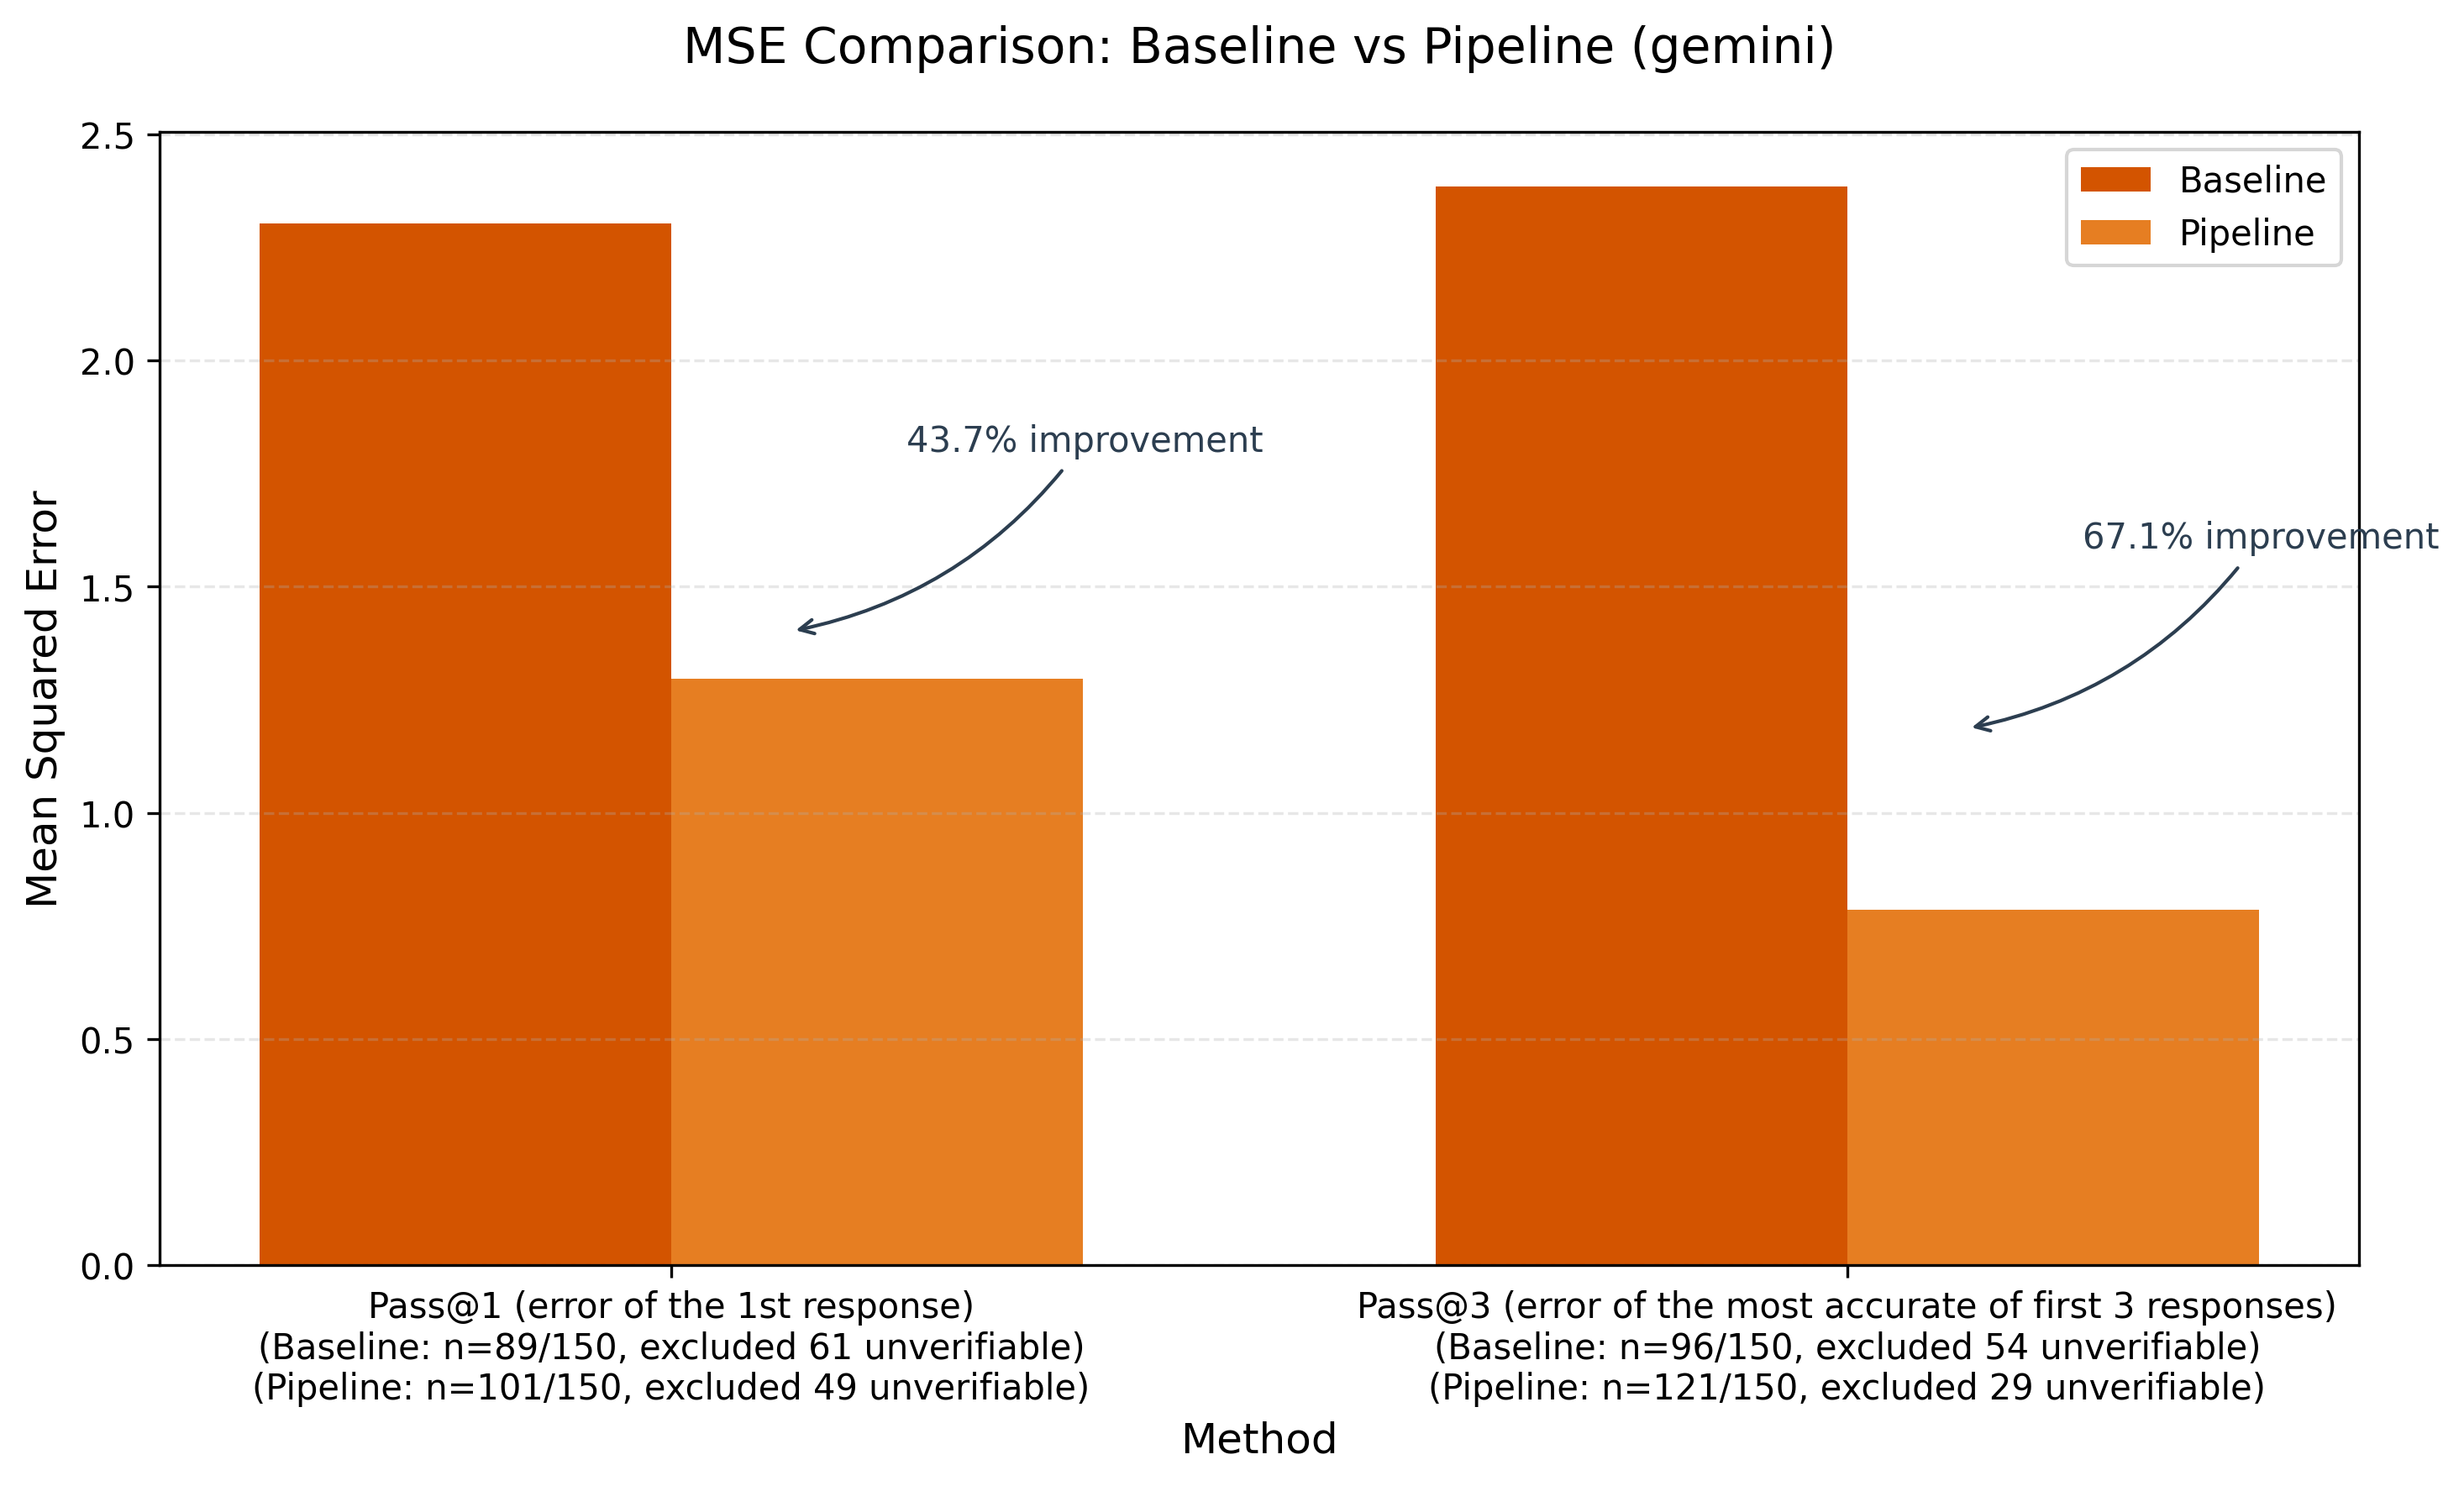

In [7]:
## PLOT: ANALYSIS EXCLUDING UNVERIFIABLE (BASELINE & PIPELINE SEPARATELY)
import numpy as np
import matplotlib.pyplot as plt

# Calculate ordinal metrics using existing MSE columns
baseline_pass1_values = df['baseline_pass1_MSE'].dropna().tolist()
pipeline_pass1_values = df['pipeline_pass1_MSE'].dropna().tolist()
baseline_pass3_values = df['baseline_pass3_MSE'].dropna().tolist()
pipeline_pass3_values = df['pipeline_pass3_MSE'].dropna().tolist()

ordinal_metrics = {
    'baseline_pass@1_mse': np.mean(baseline_pass1_values) if baseline_pass1_values else None,
    'pipeline_pass@1_mse': np.mean(pipeline_pass1_values) if pipeline_pass1_values else None,
    'baseline_pass@3_mse': np.mean(baseline_pass3_values) if baseline_pass3_values else None,
    'pipeline_pass@3_mse': np.mean(pipeline_pass3_values) if pipeline_pass3_values else None
}

# Plot results and show % improvement (from baseline to pipeline, for both pass@1 and pass@3)
plt.figure(figsize=(10, 6), dpi=300)

# Define fall colors
colors = ['#D35400', '#E67E22']  # Deep orange and lighter orange
bar_width = 0.35
index = np.arange(2)  # Two groups for Pass@1 and Pass@3

# Create bars
baseline_bars = plt.bar(index - bar_width/2, 
                       [ordinal_metrics['baseline_pass@1_mse'], ordinal_metrics['baseline_pass@3_mse']], 
                       bar_width, label='Baseline', color=colors[0])
pipeline_bars = plt.bar(index + bar_width/2, 
                       [ordinal_metrics['pipeline_pass@1_mse'], ordinal_metrics['pipeline_pass@3_mse']], 
                       bar_width, label='Pipeline', color=colors[1])

# Customize the plot
plt.xlabel('Method', fontsize=12)
plt.ylabel('Mean Squared Error', fontsize=12)
plt.title(f'MSE Comparison: Baseline vs Pipeline ({model})', fontsize=14, pad=20)
plt.xticks(index, [
    '\n'.join([
        "Pass@1 (error of the 1st response)",
        f"(Baseline: n={len(baseline_pass1_values)}/{len(df)}, excluded {len(df)-len(baseline_pass1_values)} unverifiable)",
        f"(Pipeline: n={len(pipeline_pass1_values)}/{len(df)}, excluded {len(df)-len(pipeline_pass1_values)} unverifiable)"
    ]),
    '\n'.join([
        "Pass@3 (error of the most accurate of first 3 responses)",
        f"(Baseline: n={len(baseline_pass3_values)}/{len(df)}, excluded {len(df)-len(baseline_pass3_values)} unverifiable)",
        f"(Pipeline: n={len(pipeline_pass3_values)}/{len(df)}, excluded {len(df)-len(pipeline_pass3_values)} unverifiable)"
    ])
])
plt.legend()

# Add improvement arrows and percentages
for idx, (baseline_val, pipeline_val) in enumerate([
    (ordinal_metrics['baseline_pass@1_mse'], ordinal_metrics['pipeline_pass@1_mse']),
    (ordinal_metrics['baseline_pass@3_mse'], ordinal_metrics['pipeline_pass@3_mse'])
]):
    improvement = ((baseline_val - pipeline_val) / baseline_val * 100)
    
    # Draw arrow
    mid_height = (baseline_val + pipeline_val) / 2
    plt.annotate(
        f'{improvement:.1f}% improvement', 
        xy=(idx + 0.1, mid_height - 0.4),
        xytext=(idx + 0.2, mid_height),
        fontsize=10,
        color='#2C3E50',  # Dark blue-gray
        arrowprops=dict(
            arrowstyle='->',
            color='#2C3E50',
            connectionstyle='arc3,rad=-0.2'
        )
    )

# Add grid for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.3)

# Adjust layout
plt.tight_layout()

In [439]:
# Find average error by verdict type
display(df.groupby('verdict')['pipeline_pass3_MSE'].mean())

# # Find statements where pipeline performed much better/worse than baseline
# df['error_difference'] = df['pipeline_pass1_error'] - df['baseline_pass1_error']
# display(df.nlargest(5, 'error_difference')[['statement', 'verdict', 'error_difference']])

verdict
FALSE           0.297297
HALF TRUE       1.142857
MOSTLY FALSE    0.636364
MOSTLY TRUE     0.900000
TRUE            1.333333
Name: pipeline_pass3_MSE, dtype: float64

In [437]:
# # ANALYSIS OF MSE (NO PASS@1 OR PASS@3)
# import numpy as np
# import matplotlib.pyplot as plt

# # Calculate ordinal metrics (just MSE for now)
# ordinal_metrics = {}

# # Define the ordinal mapping
# VERDICT_MAP = {
#     "TRUE": 5,
#     "MOSTLY TRUE": 4,
#     "HALF TRUE": 3,
#     "MOSTLY FALSE": 2,
#     "FALSE": 1,
#     "UNVERIFIABLE": 0,
#     # Weird cases
#     "MOSTLY UNVERIFIABLE": 0,}

# # Convert verdicts to numeric values
# true_verdicts = [VERDICT_MAP[v] for v in df['verdict']]

# # Calculate average errors across all 3 predictions
# avg_errors = []
# for i in range(len(df)):
#     true_val = true_verdicts[i]
    
#     # Get non-UNVERIFIABLE predictions
#     baseline_preds = [VERDICT_MAP[p] for p in df['pred_verdicts_baseline'][i] if p != "UNVERIFIABLE"]
#     pipeline_preds = [VERDICT_MAP[p] for p in df['pred_verdicts_pipeline'][i] if p != "UNVERIFIABLE"]
    
#     # Skip only if both have no valid predictions
#     if len(baseline_preds) == 0 and len(pipeline_preds) == 0:
#         continue
        
#     # Calculate average error for each method if predictions available
#     baseline_error = np.mean([(p - true_val)**2 for p in baseline_preds]) if baseline_preds else None
#     pipeline_error = np.mean([(p - true_val)**2 for p in pipeline_preds]) if pipeline_preds else None
    
#     avg_errors.append({
#         'baseline': baseline_error,
#         'pipeline': pipeline_error
#     })

# baseline_values = [e['baseline'] for e in avg_errors if e['baseline'] is not None]
# pipeline_values = [e['pipeline'] for e in avg_errors if e['pipeline'] is not None]

# # Calculate MSE for each case, filtering out None values
# ordinal_metrics['baseline_mse'] = np.mean(baseline_values) if baseline_values else None
# ordinal_metrics['pipeline_mse'] = np.mean(pipeline_values) if pipeline_values else None

# # Plot results and show % improvement
# plt.figure(figsize=(10, 6), dpi=300)

# # Define fall colors
# colors = ['#D35400', '#E67E22']  # Deep orange and lighter orange
# bar_width = 0.35
# index = np.array([0])  # Single group for average MSE

# # Create bars
# baseline_bars = plt.bar(index - bar_width/2, 
#                        [ordinal_metrics['baseline_mse']], 
#                        bar_width, label='Baseline', color=colors[0])
# pipeline_bars = plt.bar(index + bar_width/2, 
#                        [ordinal_metrics['pipeline_mse']], 
#                        bar_width, label='Pipeline', color=colors[1])

# # Customize the plot
# plt.xlabel('Method', fontsize=12)
# plt.ylabel('Mean Squared Error', fontsize=12)
# plt.title(f'Average MSE Comparison: Baseline vs Pipeline ({model})', fontsize=14, pad=20)
# plt.xticks(index, [
#     '\n'.join([
#         "Average MSE across all predictions",
#         f"(Baseline: n={len(baseline_values)}/{len(df)}, excluded {len(df)-len(baseline_values)} unverifiable)",
#         f"(Pipeline: n={len(pipeline_values)}/{len(df)}, excluded {len(df)-len(pipeline_values)} unverifiable)"
#     ])
# ])
# plt.legend()

# # Add improvement arrow and percentage
# baseline_val = ordinal_metrics['baseline_mse']
# pipeline_val = ordinal_metrics['pipeline_mse']
# improvement = ((baseline_val - pipeline_val) / baseline_val * 100)

# # Draw arrow
# mid_height = (baseline_val + pipeline_val) / 2
# plt.annotate(
#     f'{improvement:.1f}% improvement', 
#     xy=(0.1, mid_height - 0.4),
#     xytext=(0.2, mid_height),
#     fontsize=10,
#     color='#2C3E50',  # Dark blue-gray
#     arrowprops=dict(
#         arrowstyle='->',
#         color='#2C3E50',
#         connectionstyle='arc3,rad=-0.2'
#     )
# )

# # Add grid for better readability
# plt.grid(True, axis='y', linestyle='--', alpha=0.3)

# # Adjust layout
# plt.tight_layout()

In [436]:
# ## ANALYSIS EXCLUDING UNVERIFIABLE (BASELINE & PIPELINE TOGETHER)
# import numpy as np
# import matplotlib.pyplot as plt

# # Calculate ordinal metrics (just MSE for now)
# ordinal_metrics = {}

# # Define the ordinal mapping
# VERDICT_MAP = {
#     "TRUE": 5,
#     "MOSTLY TRUE": 4,
#     "HALF TRUE": 3,
#     "MOSTLY FALSE": 2,
#     "FALSE": 1,
#     "UNVERIFIABLE": 0,
#     # Weird cases
#     "MOSTLY UNVERIFIABLE": 0,}

# # Convert verdicts to numeric values
# true_verdicts = [VERDICT_MAP[v] for v in df['verdict']]

# # Calculate pass@1 errors
# pass1_errors = []
# for i in range(len(df)):
#     baseline_pred = df['pred_verdicts_baseline'][i][0]
#     pipeline_pred = df['pred_verdicts_pipeline'][i][0]
    
#     # Skip if either prediction is UNVERIFIABLE
#     if baseline_pred == "UNVERIFIABLE" or pipeline_pred == "UNVERIFIABLE":
#         continue
        
#     true_val = true_verdicts[i]
#     baseline_val = VERDICT_MAP[baseline_pred]
#     pipeline_val = VERDICT_MAP[pipeline_pred]
    
#     pass1_errors.append({
#         'baseline': (true_val - baseline_val) ** 2,
#         'pipeline': (true_val - pipeline_val) ** 2
#     })

# # Calculate pass@3 errors
# pass3_errors = []
# for i in range(len(df)):
#     true_val = true_verdicts[i]
    
#     # Get non-UNVERIFIABLE predictions
#     baseline_preds = [VERDICT_MAP[p] for p in df['pred_verdicts_baseline'][i] if p != "UNVERIFIABLE"]
#     pipeline_preds = [VERDICT_MAP[p] for p in df['pred_verdicts_pipeline'][i] if p != "UNVERIFIABLE"]
    
#     # Skip only if both have no valid predictions
#     if len(baseline_preds) == 0 and len(pipeline_preds) == 0:
#         continue
        
#     # Calculate errors using best non-UNVERIFIABLE prediction if available, otherwise use None
#     baseline_error = min([(p - true_val)**2 for p in baseline_preds]) if baseline_preds else None
#     pipeline_error = min([(p - true_val)**2 for p in pipeline_preds]) if pipeline_preds else None
    
#     pass3_errors.append({
#         'baseline': baseline_error,
#         'pipeline': pipeline_error
#     })

# # Calculate MSE for each case, filtering out None values
# ordinal_metrics['baseline_pass@1_mse'] = np.mean([e['baseline'] for e in pass1_errors])
# ordinal_metrics['pipeline_pass@1_mse'] = np.mean([e['pipeline'] for e in pass1_errors])
# ordinal_metrics['baseline_pass@3_mse'] = np.mean([e['baseline'] for e in pass3_errors if e['baseline'] is not None])
# ordinal_metrics['pipeline_pass@3_mse'] = np.mean([e['pipeline'] for e in pass3_errors if e['pipeline'] is not None])

# # Plot results and show % improvement (from baseline to pipeline, for both pass@1 and pass@3)
# plt.figure(figsize=(10, 6), dpi=300)

# # Define fall colors
# colors = ['#D35400', '#E67E22']  # Deep orange and lighter orange
# bar_width = 0.35
# index = np.arange(2)  # Two groups for Pass@1 and Pass@3

# # Create bars
# baseline_bars = plt.bar(index - bar_width/2, 
#                        [ordinal_metrics['baseline_pass@1_mse'], ordinal_metrics['baseline_pass@3_mse']], 
#                        bar_width, label='Baseline', color=colors[0])
# pipeline_bars = plt.bar(index + bar_width/2, 
#                        [ordinal_metrics['pipeline_pass@1_mse'], ordinal_metrics['pipeline_pass@3_mse']], 
#                        bar_width, label='Pipeline', color=colors[1])

# # Customize the plot
# plt.xlabel('Method', fontsize=12)
# plt.ylabel('Mean Squared Error', fontsize=12)
# plt.title(f'MSE Comparison: Baseline vs Pipeline ({model})', fontsize=14, pad=20)
# plt.xticks(index, [
#     '\n'.join([
#         "Pass@1 (error of the 1st response)",
#         f"(n={len(pass1_errors)}/{len(df)}, excluded {len(df)-len(pass1_errors)} unverifiable)"
#     ]),
#     '\n'.join([
#         "Pass@3 (error of the most accurate of first 3 responses)",
#         f"(n={len(pass3_errors)}/{len(df)}, excluded {len(df)-len(pass3_errors)} unverifiable)"
#     ])
# ])
# plt.legend()

# # Add improvement arrows and percentages
# for idx, (baseline_val, pipeline_val) in enumerate([
#     (ordinal_metrics['baseline_pass@1_mse'], ordinal_metrics['pipeline_pass@1_mse']),
#     (ordinal_metrics['baseline_pass@3_mse'], ordinal_metrics['pipeline_pass@3_mse'])
# ]):
#     improvement = ((baseline_val - pipeline_val) / baseline_val * 100)
    
#     # Draw arrow
#     mid_height = (baseline_val + pipeline_val) / 2
#     plt.annotate(
#         f'{improvement:.1f}% improvement', 
#         xy=(idx + 0.1, mid_height - 0.4),
#         xytext=(idx + 0.2, mid_height),
#         fontsize=10,
#         color='#2C3E50',  # Dark blue-gray
#         arrowprops=dict(
#             arrowstyle='->',
#             color='#2C3E50',
#             connectionstyle='arc3,rad=-0.2'
#         )
#     )

# # Add grid for better readability
# plt.grid(True, axis='y', linestyle='--', alpha=0.3)

# # Adjust layout
# plt.tight_layout()

In [176]:
# from sklearn.metrics import confusion_matrix

# def get_first_predictions(prediction_list):
#     """Extract first prediction from each trial list"""
#     return [pred_list[0] for pred_list in prediction_list]

# def create_confusion_matrices(df):
#     """Generate and plot confusion matrices for both models"""
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    
#     for idx, model in enumerate(['baseline', 'pipeline']):
#         first_preds = get_first_predictions(df[f'pred_verdicts_{model}'])
#         cm = confusion_matrix(df['verdict'], first_preds, labels=VERDICTS)
        
#         # Normalize confusion matrix
#         cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
#         sns.heatmap(cm_norm, annot=True, fmt='.2f', 
#                    xticklabels=VERDICTS, yticklabels=VERDICTS,
#                    ax=[ax1, ax2][idx], cmap='YlOrRd')
#         [ax1, ax2][idx].set_title(f'{model.capitalize()} Model Confusion Matrix')
#         [ax1, ax2][idx].set_xticklabels(VERDICTS, rotation=45)
        
#     plt.tight_layout()
#     return fig

# def analyze_consistency(df):
#     """Analyze model consistency across trials"""
#     consistency_metrics = {}
    
#     for model in ['baseline', 'pipeline']:
#         pred_col = f'pred_verdicts_{model}'
        
#         # Calculate percentage of consistent predictions across trials
#         consistency = df[pred_col].apply(lambda x: len(set(x)) == 1)
#         consistency_metrics[f'{model}_consistency'] = consistency.mean()
        
#         # Analyze most common disagreements
#         disagreements = df[~consistency][['verdict', pred_col]].copy()
#         disagreements['prediction_set'] = disagreements[pred_col].apply(lambda x: tuple(sorted(set(x))))
        
#         # Count most common disagreement patterns
#         consistency_metrics[f'{model}_common_disagreements'] = disagreements['prediction_set'].value_counts().head()
    
#     return consistency_metrics

# def analyze_performance_by_category(df):
#     """Analyze performance on different verdict categories"""
#     fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    
#     # Clear cases (TRUE/FALSE) vs nuanced cases
#     clear_cases = df[df['verdict'].isin(['TRUE', 'FALSE'])]
#     nuanced_cases = df[df['verdict'].isin(['MOSTLY TRUE', 'MOSTLY FALSE', 'HALF TRUE'])]
    
#     for idx, (cases, title) in enumerate([(clear_cases, 'Clear Cases'), 
#                                         (nuanced_cases, 'Nuanced Cases')]):
#         accuracy_data = []
#         for model in ['baseline', 'pipeline']:
#             first_preds = get_first_predictions(cases[f'pred_verdicts_{model}'])
#             accuracy = (cases['verdict'] == first_preds).mean()
#             accuracy_data.append({'Model': model.capitalize(), 'Accuracy': accuracy})
        
#         accuracy_df = pd.DataFrame(accuracy_data)
#         sns.barplot(data=accuracy_df, x='Model', y='Accuracy', ax=axes[idx])
#         axes[idx].set_title(f'Accuracy on {title}')
#         axes[idx].set_ylim(0, 1)
    
#     plt.tight_layout()
#     return fig

# def generate_summary_report(df):
#     """Generate comprehensive analysis report"""
#     # Calculate all metrics
#     # ordinal_metrics = calculate_ordinal_metrics(df)
#     consistency_metrics = analyze_consistency(df)
    
#     # Generate figures
#     confusion_fig = create_confusion_matrices(df)
#     performance_fig = analyze_performance_by_category(df)
    
#     # Print summary
#     print("\nAnalysis Summary:")
#     print("\nOrdinal Metrics:")
#     for metric, value in ordinal_metrics.items():
#         print(f"{metric}: {value:.4f}")
    
#     print("\nConsistency Metrics:")
#     for metric, value in consistency_metrics.items():
#         if isinstance(value, float):
#             print(f"{metric}: {value:.4f}")
#         else:
#             print(f"\n{metric}:")
#             print(value)
    
#     # Save figures
#     confusion_fig.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
#     performance_fig.savefig('performance_comparison.png', dpi=300, bbox_inches='tight')
    
#     return ordinal_metrics, consistency_metrics

# # Run the analysis
# metrics, consistency = generate_summary_report(df)

## AggreFact

In [15]:

# Make new column that checks if the true verdict is in the top 3 of the model's verdicts
# df_aggre['pred_verdicts_baseline_top3'] = df_aggre.apply(lambda row: row['verdict'] in row['pred_verdicts_baseline'][:3], axis=1)
# df_aggre['pred_verdicts_pipeline_top3'] = df_aggre.apply(lambda row: row['verdict'] in row['pred_verdicts_pipeline'][:3], axis=1)

# Clean up verdicts with extraneous text (not the cleanest/fastest method but it works)
# "UNVERIFIABLE (as of the time of writing, the statement cannot be definitively verified or refuted)": 0,
# 'UNVERIFIABLE (as of now)': 0,
# 'MOSTLY FALSE (for the first claim) and FALSE (for the second claim)': 2,
# # 'MOSTLY TRUE - Kelly Ayotte accurately mentioned a relevant bill regarding sanctuary states, but it is unclear if Joyce Craig opposed the bill since she was no longer in office when it was introduced.': 4,
# for i, row in df_aggre.iterrows():
#     cols = ['pred_verdicts_baseline', 'pred_verdicts_pipeline']
#     for col in cols: 
#         verdicts = row[col]
#         verdicts = [v.split(':')[0].split('-')[0].split('(')[0].strip() if len(v) > 12 else v for v in verdicts]
#         df_aggre.at[i, col] = verdicts

# df_aggre[['verdict', 'pred_verdicts_baseline', 'pred_verdicts_pipeline']]

In [ ]:
import sys
sys.path.append('../pipeline_v2/')
import main 
import pandas as pd

model = "gemini"

df_aggre = pd.read_pickle(f'aggrefact_{model}.pkl')

df_aggre[f'{model}_baseline_results'] = df_aggre[f'{model}_baseline_results'].apply(lambda x: [result['verdict'] for result in x] if x else None)
df_aggre[f'{model}_results'] = df_aggre[f'{model}_results'].apply(lambda x: [result['verdict'] for result in x] if x else None)

In [ ]:
equiv = {1:'supported', 0:'unsupported'}
df_aggre["verdict"] = df_aggre["label"].map(equiv)
df_aggre[f'{model}_results_top1'] = df_aggre.apply(lambda row: row['verdict'] in row[f'{model}_results'][:1], axis=1)
df_aggre[f'{model}_baseline_results_top1'] = df_aggre.apply(lambda row: row['verdict'] in row[f'{model}_baseline_results'][:1], axis=1)
df_aggre[f'{model}_results_top3'] = df_aggre.apply(lambda row: row['verdict'] in row[f'{model}_results'][:3], axis=1)
df_aggre[f'{model}_baseline_results_top3'] = df_aggre.apply(lambda row: row['verdict'] in row[f'{model}_baseline_results'][:3], axis=1)

In [ ]:
print(df_aggre[f'{model}_results_top3'].value_counts() / len(df_aggre))
print(df_aggre[f'{model}_baseline_results_top3'].value_counts() / len(df_aggre))
print(df_aggre[f'{model}_results_top1'].value_counts() / len(df_aggre))
print(df_aggre[f'{model}_baseline_results_top1'].value_counts() / len(df_aggre))

In [ ]:
print(df_aggre[f'{model}_results_top3'].value_counts() / len(df_aggre))
print(df_aggre[f'{model}_baseline_results_top3'].value_counts() / len(df_aggre))
print(df_aggre[f'{model}_results_top1'].value_counts() / len(df_aggre))
print(df_aggre[f'{model}_baseline_results_top1'].value_counts() / len(df_aggre))